In [ ]:
# install dependencies:
!pip install -q cython pyyaml==5.1
!pip install -q -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
import sys

# Install detectron2 from source
!pip install -q git+https://github.com/facebookresearch/detectron2.git

import os, json, random
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt

from detectron2.utils.visualizer import Visualizer
from detectron2.data.datasets import register_coco_instances
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2 import model_zoo

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 477.3/477.3 kB 30.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 67.6 MB/s eta 0

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Path to dataset folder
base_path = "/content/drive/MyDrive/RM_Segmentation_Assignment_dataset"
target_classes = {"person": 0, "dog": 1, "car": 2, "cake": 3}


Mounted at /content/drive


In [ ]:
import json
import os # Import os to use os.path.join

# Use the base_path variable to construct the correct file path
original_ann_path = os.path.join(base_path, "train-300", "labels.json")

# Load original annotation file
with open(original_ann_path) as f:
    coco_data = json.load(f)

# Filter annotations
cleaned_annotations = [
    ann for ann in coco_data['annotations']
    if ann.get("category_id") in [0, 1, 2, 3]
    and ann.get("segmentation")
    and ann.get("bbox")
    and ann["bbox"][2] > 0 and ann["bbox"][3] > 0
]

# Update the annotation list
coco_data['annotations'] = cleaned_annotations

# Save the cleaned file
# Use the base_path variable to save the cleaned file in the correct location
cleaned_ann_path = os.path.join(base_path, "train-300", "labels_cleaned.json") # Using a new name to avoid overwriting original
with open(cleaned_ann_path, 'w') as f:
    json.dump(coco_data, f)

print(f"Cleaned annotations saved. Total valid annotations: {len(cleaned_annotations)}")

Cleaned annotations saved. Total valid annotations: 120


In [ ]:
from detectron2.data.datasets import register_coco_instances
import os # Import os for path joining

# Define dataset names
train_dataset_name = "seg_train"
val_dataset_name = "seg_val"

# Check if datasets are already registered and unregister if they are
if train_dataset_name in DatasetCatalog.list():
    DatasetCatalog.remove(train_dataset_name)
if train_dataset_name in MetadataCatalog.list():
     MetadataCatalog.remove(train_dataset_name)

if val_dataset_name in DatasetCatalog.list():
    DatasetCatalog.remove(val_dataset_name)
if val_dataset_name in MetadataCatalog.list():
     MetadataCatalog.remove(val_dataset_name)


# Correct paths using base_path
train_cleaned_ann_path = os.path.join(base_path, "train-300", "labels_cleaned.json")
train_img_dir = os.path.join(base_path, "train-300", "data")

# Assuming you want to use the original validation labels as in your original code
# If you want to use labels_filtered.json for validation, change "labels.json" to "labels_filtered.json"
val_ann_path = os.path.join(base_path, "validation-300", "labels.json")
val_img_dir = os.path.join(base_path, "validation-300", "data")


# Register datasets
register_coco_instances(
    train_dataset_name,
    {},
    train_cleaned_ann_path,
    train_img_dir
)

register_coco_instances(
    val_dataset_name,
    {},
    val_ann_path,
    val_img_dir
)

# Optional: Print to confirm registration
print(f"Dataset '{train_dataset_name}' registered with json_file: {MetadataCatalog.get(train_dataset_name).json_file}")
print(f"Dataset '{val_dataset_name}' registered with json_file: {MetadataCatalog.get(val_dataset_name).json_file}")

Dataset 'seg_train' registered with json_file: /content/drive/MyDrive/RM_Segmentation_Assignment_dataset/train-300/labels_cleaned.json
Dataset 'seg_val' registered with json_file: /content/drive/MyDrive/RM_Segmentation_Assignment_dataset/validation-300/labels.json


In [ ]:
from detectron2.data import MetadataCatalog

# Assuming target_classes is defined in a previous cell and is accessible
# target_classes = {"person": 0, "dog": 1, "car": 2, "cake": 3}

# Get the metadata for the registered datasets
train_metadata = MetadataCatalog.get("seg_train")
val_metadata = MetadataCatalog.get("seg_val")

# Set the thing_classes attribute based on target_classes
# Ensure the order matches the category IDs
class_names = [name for name, id in sorted(target_classes.items(), key=lambda item: item[1])]

train_metadata.set(thing_classes=class_names)
val_metadata.set(thing_classes=class_names)


print("Train classes:", train_metadata.thing_classes)
print("Val classes:", val_metadata.thing_classes)

Train classes: ['person', 'dog', 'car', 'cake']
Val classes: ['person', 'dog', 'car', 'cake']


In [ ]:
def filter_and_remap(split):
    ann_path = os.path.join(base_path, split, "labels.json")
    with open(ann_path, 'r') as f:
        coco = json.load(f)

    id_map = {}
    new_categories = []
    for cat in coco["categories"]:
        if cat["name"] in target_classes:
            new_id = target_classes[cat["name"]]
            id_map[cat["id"]] = new_id
            new_categories.append({"id": new_id, "name": cat["name"]})

    new_annotations = []
    image_ids = set()
    for ann in coco["annotations"]:
        if ann["category_id"] in id_map:
            ann["category_id"] = id_map[ann["category_id"]]
            new_annotations.append(ann)
            image_ids.add(ann["image_id"])

    new_images = [img for img in coco["images"] if img["id"] in image_ids]

    new_coco = {
        "images": new_images,
        "annotations": new_annotations,
        "categories": new_categories
    }

    out_path = os.path.join(base_path, split, "labels_filtered.json")
    with open(out_path, 'w') as f:
        json.dump(new_coco, f)

    print(f" Filtered & remapped {split} → saved at {out_path}")

filter_and_remap("train-300")
filter_and_remap("validation-300")


✅ Filtered & remapped train-300 → saved at /content/drive/MyDrive/RM_Segmentation_Assignment_dataset/train-300/labels_filtered.json
✅ Filtered & remapped validation-300 → saved at /content/drive/MyDrive/RM_Segmentation_Assignment_dataset/validation-300/labels_filtered.json


In [ ]:
import json
import os # Import os to use os.path.join

# Use the base_path variable to construct the correct file path
filtered_ann_path = os.path.join(base_path, "train-300", "labels_filtered.json")

with open(filtered_ann_path, "r") as f:
    data = json.load(f)

all_cat_ids = set([ann['category_id'] for ann in data['annotations']])
print("Used category_ids in training set:", all_cat_ids)

Used category_ids in training set: {0, 1, 2, 3}


In [ ]:
# Define dataset names
train_dataset_name = "seg_train"
val_dataset_name = "seg_val"

# Check if datasets are already registered and unregister if they are
if train_dataset_name in DatasetCatalog.list():
    DatasetCatalog.remove(train_dataset_name)
if train_dataset_name in MetadataCatalog.list():
     MetadataCatalog.remove(train_dataset_name)

if val_dataset_name in DatasetCatalog.list():
    DatasetCatalog.remove(val_dataset_name)
if val_dataset_name in MetadataCatalog.list():
     MetadataCatalog.remove(val_dataset_name)


train_img_dir = os.path.join(base_path, "train-300", "data")
val_img_dir = os.path.join(base_path, "validation-300", "data")
train_ann_path = os.path.join(base_path, "train-300", "labels_filtered.json")
val_ann_path = os.path.join(base_path, "validation-300", "labels_filtered.json")

register_coco_instances("seg_train", {}, train_ann_path, train_img_dir)
register_coco_instances("seg_val", {}, val_ann_path, val_img_dir)

train_metadata = MetadataCatalog.get("seg_train")
val_metadata = MetadataCatalog.get("seg_val")

Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.



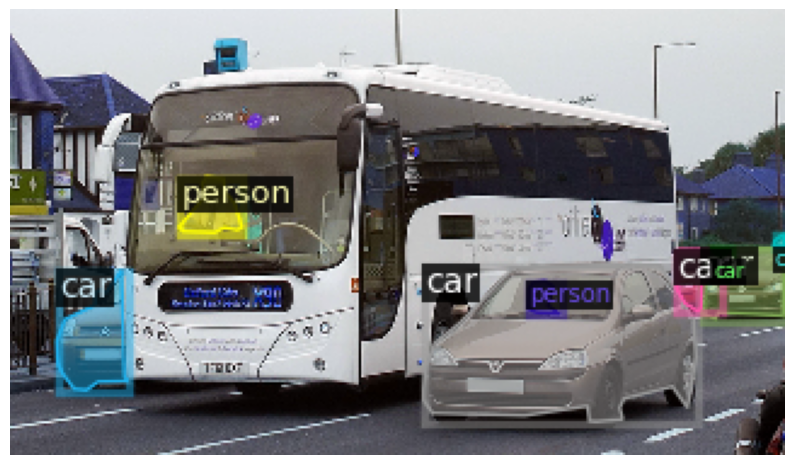

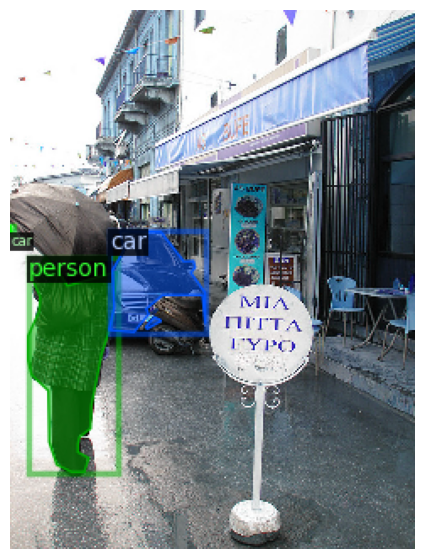

In [ ]:
dataset_dicts = DatasetCatalog.get("seg_train")
for d in random.sample(dataset_dicts, 2):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=train_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    plt.figure(figsize=(10, 7))
    plt.imshow(vis.get_image()[:, :, ::-1])
    plt.axis("off")
    plt.show()


In [ ]:
# Assuming 'data' from cell Pd2Oq1o7sVVe contains the loaded training annotations
for ann in data["annotations"]:
    if "category_id" in ann and ann["category_id"] > 4: # Adjusted check based on 4 classes (1-4)
        print("Invalid category ID:", ann)
    if "segmentation" not in ann or len(ann["segmentation"]) == 0:
        print("Missing segmentation:", ann)
    if "bbox" in ann and (ann["bbox"][2] <= 0 or ann["bbox"][3] <= 0):
        print("Invalid bbox:", ann)

In [ ]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2 import model_zoo
import os

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file(
    "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))

cfg.DATASETS.TRAIN = ("seg_train",)
cfg.DATASETS.TEST = ("seg_val",)
cfg.DATALOADER.NUM_WORKERS = 2

cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(
    "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")

cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 300
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 4
cfg.OUTPUT_DIR = "/content/output"
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

# Train
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()


[06/18 14:55:16 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_f10217.pkl: 178MB [00:01, 108MB/s]                           
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}


[06/18 14:55:18 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.11/dist-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[06/18 14:55:32 d2.utils.events]:  eta: 0:02:08  iter: 19  total_loss: 3.218  loss_cls: 1.55  loss_box_reg: 0.8751  loss_mask: 0.6929  loss_rpn_cls: 0.04127  loss_rpn_loc: 0.04566    time: 0.4882  last_time: 0.4480  data_time: 0.1140  last_data_time: 0.0053   lr: 1.6068e-05  max_mem: 2614M
[06/18 14:55:46 d2.utils.events]:  eta: 0:02:01  iter: 39  total_loss: 3.036  loss_cls: 1.357  loss_box_reg: 0.9038  loss_mask: 0.6868  loss_rpn_cls: 0.03637  loss_rpn_loc: 0.05769    time: 0.4733  last_time: 0.4387  data_time: 0.0111  last_data_time: 0.0101   lr: 3.2718e-05  max_mem: 2614M
[06/18 14:55:55 d2.utils.events]:  eta: 0:01:49  iter: 59  total_loss: 2.765  loss_cls: 1.058  loss_box_reg: 0.8822  loss_mask: 0.6777  loss_rpn_cls: 0.0393  loss_rpn_loc: 0.05109    time: 0.4652  last_time: 0.4610  data_time: 0.0343  last_data_time: 0.0071   lr: 4.9367e-05  max_mem: 2614M
[06/18 14:56:05 d2.utils.events]:  eta: 0:01:41  iter: 79  total_loss: 2.486  loss_cls: 0.7985  loss_box_reg: 0.8494  loss_mas

[06/18 14:58:06 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/output/model_final.pth ...


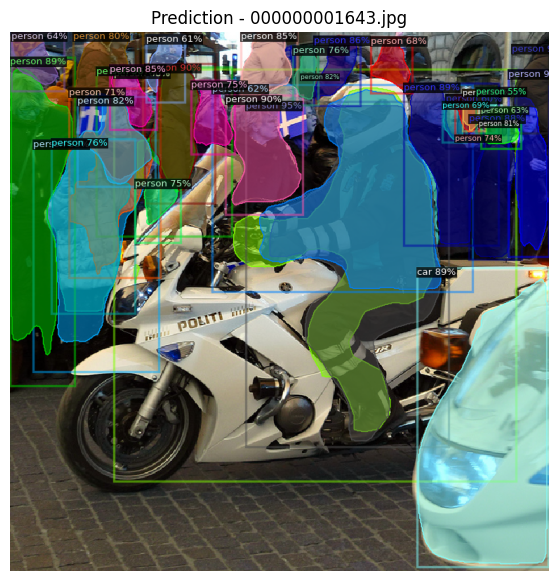

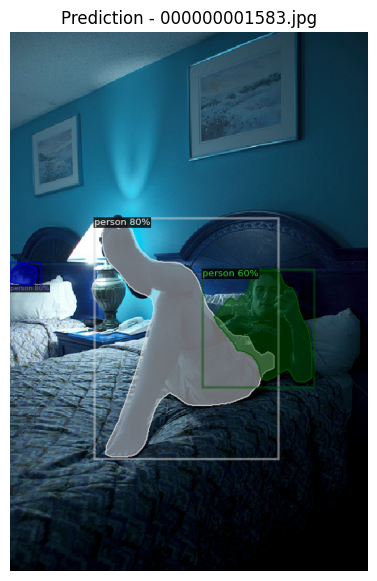

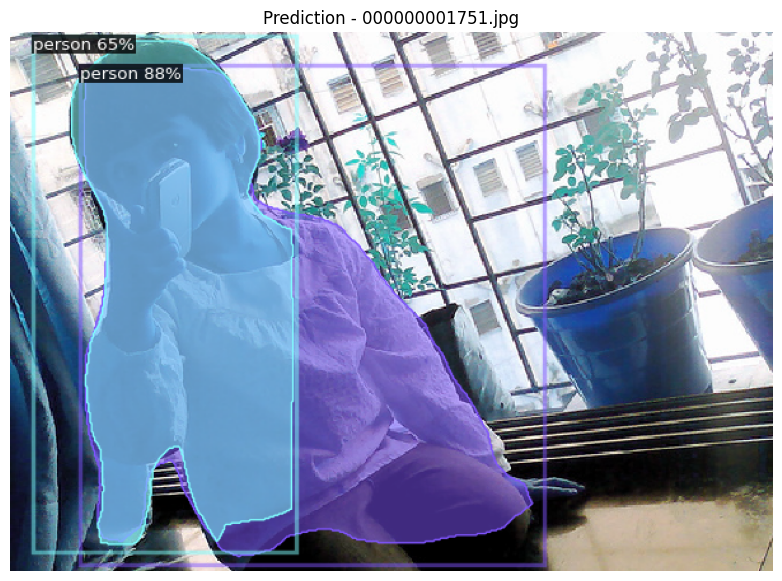

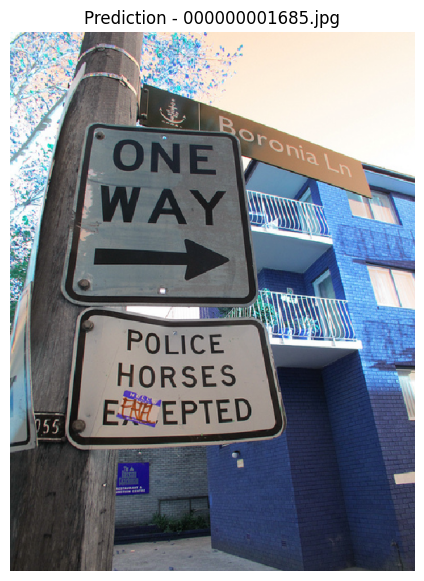

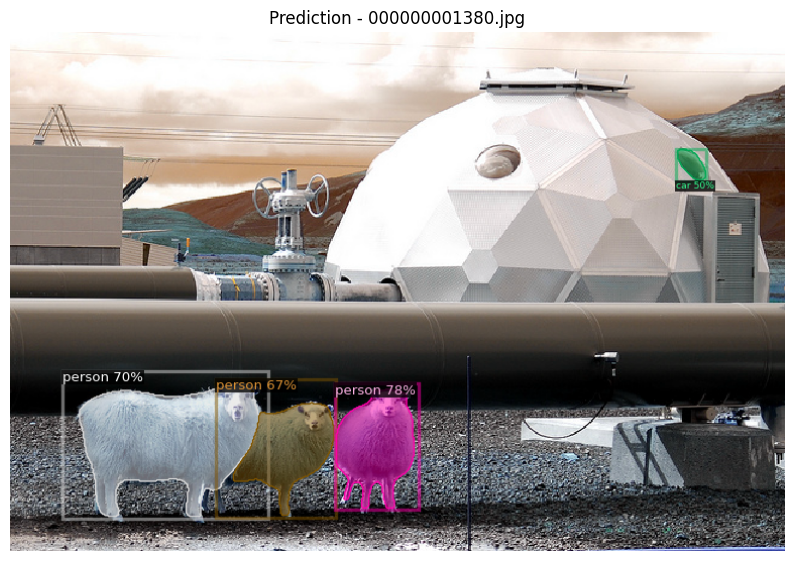

In [ ]:
from detectron2.engine import DefaultPredictor

cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
predictor = DefaultPredictor(cfg)

test_img_dir = os.path.join(base_path, "test-30")
test_images = [f for f in os.listdir(test_img_dir) if f.lower().endswith((".jpg", ".png"))]

for img_name in test_images[:5]:
    img_path = os.path.join(test_img_dir, img_name)
    im = cv2.imread(img_path)
    outputs = predictor(im)

    v = Visualizer(im[:, :, ::-1], metadata=train_metadata, scale=1.2)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

    plt.figure(figsize=(10, 7))
    plt.imshow(out.get_image()[:, :, ::-1])
    plt.title(f"Prediction - {img_name}")
    plt.axis("off")
    plt.show()
